In [65]:
import tensorflow as tf
import numpy as np
#The MNIST dataset comprises 60,000 training examples and 10,000 test examples 
#of the handwritten digits 0–9, formatted as 28x28-pixel monochrome images.

#We store the training feature data (the raw pixel values for 60,000 images of hand-drawn digits) 
#and training labels (the corresponding value from 0–9 for each image) 
#as numpy arrays in train_data and train_labels, respectively. 
#Similarly, we store the evaluation feature data (10,000 images) and evaluation labels in eval_data and eval_labels, 
#respectively.

# train_data is an array of matrix 28x28. 0 is black 255 is white
((train_data, train_labels), (eval_data, eval_labels)) = tf.keras.datasets.mnist.load_data()



In [66]:
#cnn_model_fn function, which conforms to the interface expected by TensorFlow's Estimator
#mode:TRAIN training phase, EVAL: testing phase, PREDICT:inferencing,predicting phase
#A tensor is a generalization of vectors and matrices to potentially higher dimensions.
def cnn_model_fn(features, labels, mode):
    #expect input tensors to have a shape of [batch_size, image_height, image_width, channels]
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1]) #-1 means dynamic batch_size holding the size of all other dimensions constant.  
    
    # Convolutional Layer #1
    #We want to apply 32 5x5 filters to the input layer, with a ReLU activation functio
    conv1 = tf.layers.conv2d(
    inputs=input_layer,
    filters=32,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.relu)
    
    #Our output tensor produced by conv2d() has a shape of [batch_size, 28, 28, 32]
    
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    #Our output tensor (pool1) has a shape of [batch_size, 14, 14, 32]: the 2x2 filter reduces height and width by 50% each.

  # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    #Our output tensor (conv2) has a shape of [batch_size, 14, 14, 64] . WHY 64??
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    #pool2 has shape [batch_size, 7, 7, 64]

    
  # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64]) #reshape input as linear vector: -1 preserves batch size
    
    #dense layer performs outputs = activation(inputs * kernel + bias) 
    #The units argument specifies the number of output neurons in the dense layer (1,024). 7*7*64*batch_size neurons mapped to 1024 neurons
    #activation function is relu
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
    #Our output tensor dense has shape [batch_size, 1024].
    
    
    #dropping neurons to prevent over-fitting
    #The rate argument specifies the dropout rate; here, we use 0.4, which means 40% of the elements will be randomly dropped out during training.
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    #Our output tensor dropout has shape [batch_size, 1024].
    

  # Logits Layer
  #The final layer in our neural network is the logits layer
  #with 10 neurons (one for each target class 0–9), with linear activation (by default if not specified): y = c * input
    logits = tf.layers.dense(inputs=dropout, units=10)

  #on logits layer our class is the max argument of the tensor [0,9]
  #and his probability is equal to softwax funtion value [0,1]
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    #if predict mode return a model instance to be run by an Estimator.
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes) as softmax cross entropy between label and logits
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        #train_op = minimize loss function with gradient descent
        train_op = optimizer.minimize(
          loss=loss,
          global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
    

7


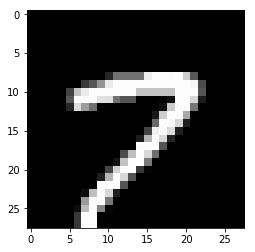

In [67]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

plt.gray() #use gray scale to show image
x = train_data[123]
plt.imshow(x) #show third image
print(train_labels[123]) #print third image label  



In [68]:
#da capire perché divide i valori dei pixel per 225 per portarli nel range [0,1]
train_data = train_data/np.float32(255)
train_labels = train_labels.astype(np.int32)  # to convert the tensor type into int32 due to limitation of type in estimator

eval_data = eval_data/np.float32(255)
eval_labels = eval_labels.astype(np.int32)  # to convert the tensor type into int32 due to limitation of type in estimator


In [69]:
#create an Estimator (a TensorFlow class for performing high-level model training, evaluation, and inference) for our model

#Estimator object wraps a model which is specified by a model_fn. 
#model_dir is the directory to save model parameters, graph and etc. This can also be used to load checkpoints from the directory into an estimator to continue training a previously saved model.
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_task_id': 0, '_service': None, '_global_id_in_cluster': 0, '_model_dir': '/tmp/mnist_convnet_model', '_master': '', '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f16041fbd30>, '_task_type': 'worker', '_save_checkpoints_steps': None, '_experimental_distribute': None, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_device_fn': None, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_tf_random_seed': None, '_num_worker_replicas': 1, '_train_distribute': None, '_save_summary_steps': 100, '_protocol': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_eval_distribute': None}


In [70]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [71]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=400,
    num_epochs=None,
    shuffle=True)

# train one step and display the probabilties
#mnist_classifier.train(
#    input_fn=train_input_fn,
#    steps=1,
#    hooks=[logging_hook]) 

#TRAIN 100 epoch
mnist_classifier.train(input_fn=train_input_fn, steps=10)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-1421
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1421 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 1.418833, step = 1422
INFO:tensorflow:Saving checkpoints for 1431 into /tmp/mnist_convnet_model/model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:Loss for final step: 1.4246651.


In [72]:
#TEST MODEL
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1, #so that the model evaluates the metrics over one epoch of data
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-07T16:12:38Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-1431
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-07-16:12:47
INFO:tensorflow:Saving dict for global step 1431: accuracy = 0.7633, global_step = 1431, loss = 1.3813535
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1431: /tmp/mnist_convnet_model/model.ckpt-1431
{'accuracy': 0.7633, 'global_step': 1431, 'loss': 1.3813535}


In [ ]:
#PREDICT values

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

predict_results = mnist_classifier.predict(
    input_fn = predict_input_fn
)


for el in predict_results:
    print(el)


